# SUDO CODE 2025

- Name: Nguyễn Anh Đức
- Team: 9
- ID: 28

## Import libs

In [23]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

## Exploring data

### Read rawdata from file

In [2]:
with open("viwik18.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
text[:500]

'trang chính  internet society  internet society hay isoc là một tổ chức quốc tế hoạt động phi lợi nhuận phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành tổ chức này chú trọng đến tiêu chuẩn giáo dục và các vấn đề về chính sách với trên một bốn năm tổ chức thành viên và sáu năm không không không thành viên cá nhân isoc bao gồm những con người cụ thể trong cộng đồng internet mọi chi tiết có thể tìm thấy tại website của isoc   internet society nằm ở gần thủ đô washington dc hoa kỳ v'

## Embeddings

### Word2Vec training using chunk splitting

In [ ]:
# Định nghĩa iterator đọc văn bản theo từng chunk
class TokenChunkIterator:
    def __init__(self, file_path, chunk_size=50_000, overlap=500):
        self.file_path = file_path
        self.chunk_size = chunk_size
        self.overlap = overlap

    def __iter__(self):
        with open(self.file_path, 'r', encoding='utf-8') as f:
            buffer = '' # Phần còn lại từ chunk trước
            while True:
                chunk = f.read(self.chunk_size)

                # Nếu hết file mà vẫn còn buffer thì yield
                if not chunk:
                    if buffer:
                        yield simple_preprocess(buffer)
                    break

                # Ghép buffer từ lần trước với chunk mới
                chunk = buffer + chunk

                # Tìm vị trí space cuối cùng để không cắt giữa từ
                last_space = chunk.rfind(' ')
                if last_space == -1:
                    last_space = len(chunk)

                # Yield phần văn bản đến vị trí space cuối cùng    
                yield simple_preprocess(chunk[:last_space])

                # Giữ lại phần còn dư để dùng cho chunk tiếp theo
                buffer = chunk[last_space - self.overlap:]

# Khởi tạo iterator
sentences = TokenChunkIterator("viwik18.txt", chunk_size=50_000)

# Khởi tạo model Word2Vec
model = Word2Vec(
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
)

# Xây dựng vocab từ iterator
model.build_vocab(sentences)

# Train model
model.train(sentences, total_examples=model.corpus_count, epochs=5)

# Lưu model
model.save("viwik18_word2vec.model")


### Word2Vec embeddings visualization

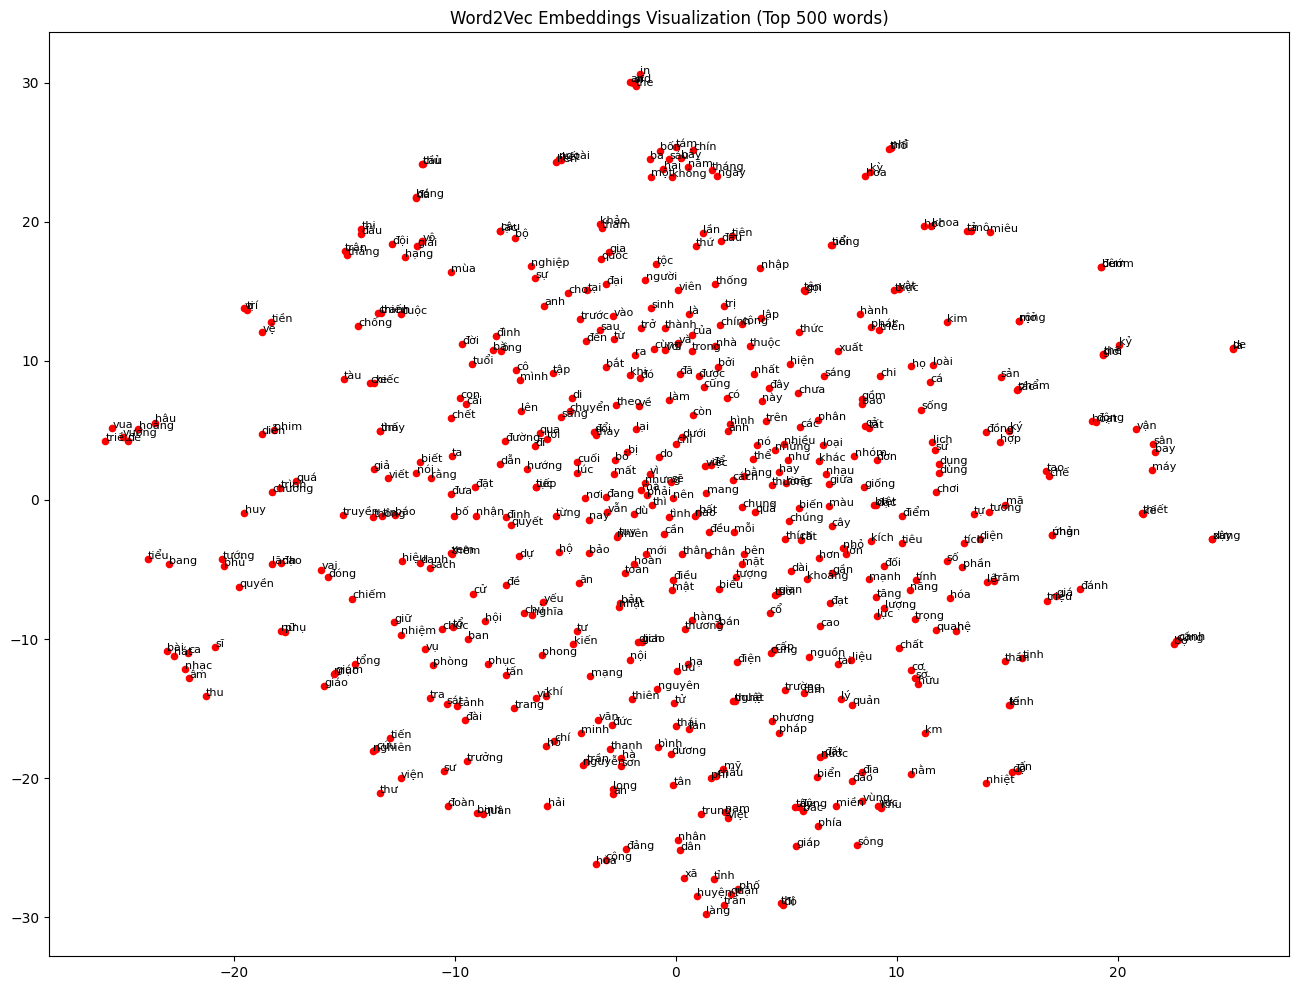

In [22]:
# Lấy top 500 từ phổ biến
top_n = 500
words = [word for word, vocab_obj in sorted(model.wv.key_to_index.items(), key=lambda x: model.wv.get_vecattr(x[0], "count"), reverse=True)[:top_n]]

# Lấy embedding vectors
vectors = np.array([model.wv[word] for word in words])

# Giảm chiều với PCA trước, sau đó t-SNE
pca = PCA(n_components=50)
vectors_pca = pca.fit_transform(vectors)

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
vectors_2d = tsne.fit_transform(vectors_pca)

# Vẽ scatter plot
plt.figure(figsize=(16,12))
plt.scatter(vectors_2d[:,0], vectors_2d[:,1], s=20, color='red')

# Gắn label
for i, word in enumerate(words):
    plt.text(vectors_2d[i,0]+0.01, vectors_2d[i,1]+0.01, word, fontsize=8)

plt.title("Word2Vec Embeddings Visualization (Top 500 words)")
plt.show()
